In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0


In [2]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-0smc6_wb
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-0smc6_wb
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit aac710a35f52bb78ab34d2e52517237941399eff
  Preparing metadata (setup.py) ... done
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-py3-none-any.whl size=4304 sha256=915b60ea69db5dc8bc2071a8e3c396d9028935b5a5b52cf96cf6f956cb026943
  Stored in directory: /tmp/pip-ephem-wheel-cache-1mqlf0nj/wheels/f3/08/cc/e2b5b0e1c92df07dbb50a6f024a68ce090f5e7b2316b41756d
Successfully built NVCCPlugin


In [3]:
%load_ext nvcc_plugin

created output directory at /content/src
Out bin /content/result.out


###Sekcje w kodzie to:

__device__: oznacza, że funkcja myfunction() jest dostępna dla urządzenia CUDA, co oznacza, że może być wykonywana na karcie graficznej.

__global__: oznacza, że funkcja integratorKernel() jest funkcją jądra CUDA, co oznacza, że może być wykonywana na wielu rdzeniach karty graficznej jednocześnie.

__host__: oznacza, że funkcje cudaIntegrate(), diffclock() i main() są dostępne dla procesora (hosta) i wykonywane są na nim.

<<<>>>: oznacza składnię CUDA do określenia liczby bloków i wątków, które mają być wykorzystane przy wywołaniu funkcji jądra CUDA integratorKernel().

##Prostokątów GPU

In [12]:
%%cu
#include <stdio.h>
#include <iostream>
using namespace std;
__device__ float myfunction(float a)
{
return 4*a*a+2.0f*a + 3.0f;
}
// funkcja kernel do obliczenia sumy wykorzystanej w metodzie prostokątów
__global__ void integratorKernel(float *a, float x0, float h, int N)
{
int idx = blockIdx.x * blockDim.x + threadIdx.x;
float x = x0 + (float)idx * h;
if (idx<N)
{
a[idx] = myfunction(x) + myfunction(x + h);
}
}
//cudaIntegrate() jest funkcją hosta, która ustawia obliczenia całki po przedziale [x0,xn]
__host__ float cudaIntegrate(float x0, float xn, int N)
{
// obliczenie h (wysokości prostokątów) potrzebnego do wzoru
float h = (xn-x0)/N;
// zmienna kodu błędu
cudaError_t errorcode = cudaSuccess;
// wielkość tablic w bitach
int size = N*sizeof(float);
// przydzielenie tablic dla hosta i urządzenia
float* a_h = (float *)malloc(size);
float* a_d;
if (( errorcode = cudaMalloc((void **)&a_d,size))!= cudaSuccess)
{
cout << "cudaMalloc(): " << cudaGetErrorString(errorcode) << endl;
exit(1);
}
// obliczenia na urządzeniu
int block_size = 256;
int n_blocks = N/block_size + ( N % block_size == 0 ? 0:1);
integratorKernel <<< n_blocks, block_size >>> (a_d, x0, h, N);
// skopiowanie wyników z urządzenia na hosta
if((errorcode = cudaMemcpy(a_h, a_d, sizeof(float)*N, cudaMemcpyDeviceToHost))!=cudaSuccess)
{
cout << "cudaMemcpy(): " << cudaGetErrorString(errorcode) << endl;
exit(1);
}
// zsumowanie wyników
float sum = 0.0;
for(int i=0; i<N; i++) sum += a_h[i];
sum *= h/2.0;
// zwolnienie pamięci
free(a_h);
cudaFree(a_d);
return sum;
}
// funkcja do pomiaru czasu wykonywania programu w mikro sekundach
__host__ double diffclock(clock_t clock1, clock_t clock2)
{
double diffticks = clock1-clock2;
double diffms = diffticks/(CLOCKS_PER_SEC/1000);
return diffms;
}
// funkcja main
int main()
{
clock_t start = clock();
float answer = cudaIntegrate(0.0,2.0,1024);
clock_t end = clock();
cout << "Wynik to: " << answer << endl;
cout << "Czas obliczeń: " << diffclock(end,start);
cout << " mikro sekund" << endl;
return 0;
}

Wynik to: 20.6667
Czas obliczeń: 704.834 mikro sekund



##Prostokątów CPU

In [22]:
%%cu
#include <stdio.h>
#include <iostream>
using namespace std;

float myfunction(float a)
{
return 4*a*a+2.0f*a + 3.0f;
}

// funkcja hosta do obliczenia sumy wykorzystanej w metodzie prostokątów
void integratorKernel(float *a, float x0, float h, int N)
{
    for(int idx = 0; idx < N; idx++)
    {
        float x = x0 + (float)idx * h;
        a[idx] = myfunction(x) + myfunction(x + h);
    }
}

// cudaIntegrate() jest funkcją hosta, która ustawia obliczenia całki po przedziale [x0,xn]
float cudaIntegrate(float x0, float xn, int N)
{
    // obliczenie h (wysokości prostokątów) potrzebnego do wzoru
    float h = (xn-x0)/N;
    // wielkość tablic w bitach
    int size = N*sizeof(float);
    // przydzielenie tablic dla hosta 
    float* a_h = (float *)malloc(size);
    // obliczenia na hosta
    integratorKernel(a_h, x0, h, N);
    // zsumowanie wyników
    float sum = 0.0;
    for(int i=0; i<N; i++) sum += a_h[i];
    sum *= h/2.0;
    // zwolnienie pamięci
    free(a_h);
    return sum;
}

// funkcja do pomiaru czasu wykonywania programu w mikro sekundach
double diffclock(clock_t clock1, clock_t clock2)
{
double diffticks = clock1-clock2;
double diffms = diffticks/(CLOCKS_PER_SEC/1000);
return diffms;
}

int main()
{
clock_t start = clock();
float answer = cudaIntegrate(0.0,2.0,1024);
clock_t end = clock();
cout << "Wynik to: " << answer << endl;
cout << "Czas obliczeń: " << diffclock(end,start);
cout << " mikro sekund" << endl;
return 0;
}

Wynik to: 20.6667
Czas obliczeń: 0.029 mikro sekund



#Trapezów GPU

In [13]:
%%cu
#include <stdio.h>
#include <iostream>
using namespace std;

__device__ float myfunction(float a)
{
return 4*a*a+2.0f*a + 3.0f;
}


// funkcja kernel do obliczenia sumy wykorzystanej w metodzie trapezów
__global__ void integratorKernel(float *a, float x0, float h, int N)
{
int idx = blockIdx.x * blockDim.x + threadIdx.x;
float x = x0 + (float)idx * h;
if (idx<N)
{
a[idx] = h * (myfunction(x + h));
}
}


//cudaIntegrate() jest funkcją hosta, która ustawia obliczenia całki po przedziale [x0,xn]
__host__ float cudaIntegrate(float x0, float xn, int N)
{
// obliczenie h (wysokości prostokątów) potrzebnego do wzoru
float h = (xn-x0)/N;
// zmienna kodu błędu
cudaError_t errorcode = cudaSuccess;
// wielkość tablic w bitach
int size = N*sizeof(float);
// przydzielenie tablic dla hosta i urządzenia
float* a_h = (float *)malloc(size);
float* a_d;
if (( errorcode = cudaMalloc((void **)&a_d,size))!= cudaSuccess)
{
cout << "cudaMalloc(): " << cudaGetErrorString(errorcode) << endl;
exit(1);
}
// obliczenia na urządzeniu
int block_size = 256;
int n_blocks = N/block_size + ( N % block_size == 0 ? 0:1);
integratorKernel <<< n_blocks, block_size >>> (a_d, x0, h, N);
// skopiowanie wyników z urządzenia na hosta
if((errorcode = cudaMemcpy(a_h, a_d, sizeof(float)*N, cudaMemcpyDeviceToHost))!=cudaSuccess)
{
cout << "cudaMemcpy(): " << cudaGetErrorString(errorcode) << endl;
exit(1);
}
// zsumowanie wyników
float sum = 0.0;
for(int i=0; i<N; i++) sum += a_h[i];
// zwolnienie pamięci
free(a_h);
cudaFree(a_d);
return sum;
}
// funkcja do pomiaru czasu wykonywania programu w mikro sekundach
__host__ double diffclock(clock_t clock1, clock_t clock2)
{
double diffticks = clock1-clock2;
double diffms = diffticks/(CLOCKS_PER_SEC/1000);
return diffms;
}
// funkcja main
int main()
{
clock_t start = clock();
float answer = cudaIntegrate(0.0,2.0,1024);
clock_t end = clock();
cout << "Wynik to: " << answer << endl;
cout << "Czas obliczeń: " << diffclock(end,start);
cout << " mikro sekund" << endl;
return 0;
}

Wynik to: 20.6862
Czas obliczeń: 687.196 mikro sekund



##Trapezów CPU

In [25]:
%%cu
#include <stdio.h>
#include <iostream>
using namespace std;

float myfunction(float a)
{
return 4*a*a+2.0f*a + 3.0f;
}

// funkcja hosta do obliczenia sumy wykorzystanej w metodzie prostokątów
void integratorKernel(float *a, float x0, float h, int N)
{
    for(int idx = 0; idx < N; idx++)
    {
        float x = x0 + (float)idx * h;
        a[idx] = h * (myfunction(x + h));
    }
}

// cudaIntegrate() jest funkcją hosta, która ustawia obliczenia całki po przedziale [x0,xn]
float cudaIntegrate(float x0, float xn, int N)
{
    // obliczenie h (wysokości prostokątów) potrzebnego do wzoru
    float h = (xn-x0)/N;
    // wielkość tablic w bitach
    int size = N*sizeof(float);
    // przydzielenie tablic dla hosta 
    float* a_h = (float *)malloc(size);
    // obliczenia na hosta
    integratorKernel(a_h, x0, h, N);
    // zsumowanie wyników
    float sum = 0.0;
    for(int i=0; i<N; i++) sum += a_h[i];
    // zwolnienie pamięci
    free(a_h);
    return sum;
}

// funkcja do pomiaru czasu wykonywania programu w mikro sekundach
double diffclock(clock_t clock1, clock_t clock2)
{
double diffticks = clock1-clock2;
double diffms = diffticks/(CLOCKS_PER_SEC/1000);
return diffms;
}

int main()
{
clock_t start = clock();
float answer = cudaIntegrate(0.0,2.0,4096);
clock_t end = clock();
cout << "Wynik to: " << answer << endl;
cout << "Czas obliczeń: " << diffclock(end,start);
cout << " mikro sekund" << endl;
return 0;
}

Wynik to: 20.6716
Czas obliczeń: 0.084 mikro sekund



#Simpsona GPU

In [29]:
%%cu
#include <stdio.h>
#include <iostream>
using namespace std;
__device__ float myfunction(float a)
{
return 4*a*a+2.0f*a + 3.0f;
}

__device__ void setLimit(int* n_start, int* n_end, int n, int bloki, int blokiwidth)
{
int threadId = blokiwidth * blockIdx.x + threadIdx.x;
int nextThreadId = threadId + 1;
 
int threads = blokiwidth * bloki;

*n_start = (threadId * n) / threads;
*n_end = (nextThreadId * n) / threads;
}

__device__ void calculateParabola(int bloki, int rdzenie, 
  double x0, double xn, int N, float* result)
{
*result = 0;
float h = (xn - x0) / N;
int idx_start;
int idx_end;
setLimit(&idx_start, &idx_end, N-1, bloki, rdzenie);
for (int i = idx_start; i < idx_end; i += 2) 
{
*result += (myfunction(x0 + h * (i - 1)) + 4 * myfunction(x0 + h * i) +
 myfunction(x0 + h * (i + 1))) * h / 3;
}
}

// funkcja wykorzystana do obliczenia sumy w metodzie Simpsona
__global__ void mtSimpsona(int bloki, int rdzenie, float* result, float x0, float xn, int N)
{
float wynik = 0;
calculateParabola(bloki, rdzenie, x0, xn, N, &wynik);
result[(blockIdx.x * rdzenie + threadIdx.x)] = wynik;
}

//simpson() jest funkcją hosta, która ustawia obliczenia całki po przedziale [x0,xn]
__host__ float simpson(float x0, float xn, int N)
{
const int bloki = 32;
const int rdzenie = 32;
 
float* a_d;
float a_h[rdzenie * bloki] = {0};
 
cudaMalloc((void**)&a_d, sizeof(float) * rdzenie * bloki);
mtSimpsona << <bloki, rdzenie>> > (bloki, rdzenie, a_d, x0, xn, N);
cudaThreadSynchronize();

cudaMemcpy(a_h, a_d, sizeof(float) * rdzenie * bloki, cudaMemcpyDeviceToHost);
 
float sum = 0;
for(int i=0; i != rdzenie * bloki; ++i) {
  sum += a_h[i];
}
cudaFree(a_d);
return sum;
}

// funkcja do pomiaru czasu wykonywania programu w mikro sekundach
__host__ double diffclock(clock_t clock1, clock_t clock2)
{
double diffticks = clock1-clock2;
double diffms = diffticks/(CLOCKS_PER_SEC/1000);
return diffms;
}
// funkcja main
int main()
{
clock_t start = clock();
float x0 = 0.0;
float xn = 2.0;
int N = 4096;
float answer = simpson(x0,xn,N);
clock_t end = clock();
cout << "Wynik to: " << answer << endl;
cout << "Czas obliczeń: " << diffclock(end,start);
cout << " mikro sekund" << endl;
return 0;
}


Wynik to: 20.6471
Czas obliczeń: 702.783 mikro sekund



#Podsumowanie
##Wyniki funkcji dla GPU
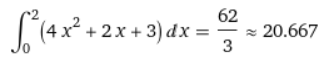

###N = 4096
####Prostokątów: 20.6667, czas obliczeń: 760.962 mikro sekund
####Trapezów: 20.6716, czas obliczeń: 770.105 mikro sekund
####Simpsona: 20.6471, czas obliczeń: 768.574 mikro sekund
###N = 2048
####Prostokątów: 20.6667, czas obliczeń: 702.776 mikro sekund
####Trapezów: 20.6765, czas obliczeń: 716.758 mikro sekund
####Simpsona: 20.6277, czas obliczeń: 698.907 mikro sekund
###N = 1024
####Prostokątów: 20.6667, czas obliczeń: 704.834 mikro sekund
####Trapezów: 20.6862, czas obliczeń: 687.196 mikro sekund
####Simpsona: 41.2046, czas obliczeń: 703.315 mikro sekund

##Wyniki dla CPU
###N = 4096
####Prostokątów: 20.6667, czas obliczeń: 0.081 mikro sekund
####Trapezów: 20.6716, czas obliczeń: 0.084 mikro sekund
####Simpsona: 
###N = 2048
####Prostokątów: 20.6667, czas obliczeń: 0.052 mikro sekund
####Trapezów: 20.6765, czas obliczeń: 0.045 mikro sekund
####Simpsona: 
###N = 1024
####Prostokątów: 20.6667, czas obliczeń: 0.029 mikro sekund
####Trapezów: 20.6862, czas obliczeń: 0.028 mikro sekund
####Simpsona: 

##Wnioski
###Jak widać, nie zawsze GPU okazuje się bardziej optymalnym rozwiązaniem. Dla powyższej funkcji metoda prostokątów okazała się być najskuteczniejszą. Metoda Simpsona wymaga o większej liczby N, aby jej wynik zbliżył się do poprawnego.